## IN450 Individual Project

## Detection, Classification and Defense of Malware in Network Traffic using Machine Learning techniques.

### Author: [Ismail Masanja](mailto:ismail.masanja@city.ac.uk)

### Supervisor: [Dr. Mohammad Saedi](mailto:mohammad.saedi@city.ac.uk)

`This Notebook is primarly for training Classification Models` that is, in the data, there is a **Label** column indicating whether the connection is Benign or Malicious. It is then up to the model to Classify the type of the attack.


#### 1. Introduction

This notebook's aim is to train classification models. Classification models perform multi-class classification. The classification labels are: DDoS, Reconnaissance, Injection, DoS, Brute Force, Password, XSS, Infilteration, Exploits, Scanning, Fuzzers, Backdoor, Bot, Generic, Analysis, Theft,Shellcode, MITM,Worms, Ransomware. Before running the notebook data preprocessing of [NF-UQ-NIDS-v2](https://staff.itee.uq.edu.au/marius/NIDS_datasets/) Dataset.

In summary, preprocessing is done offline using bash script -- for faster preprocessing. Preprocessing involves four main steps (i), Separating every row of the csv -- based on the attack field and saving these csvs of different attack types. (ii), Choosing a training, validation and testing ratio. (iii) Based on these ratios, in that particular part of the section rows are selected. (iv), To Balance data -- to ensure better model perfomance if a particular section has few occurences the rows are selected again and again (in cyclic form) -- **Over Sampling**. More detailed information about preprocessing if found in final report.


#### 2. Imports

This section imports all the necessary dependacies needed to run the notebook.


In [1]:
import sys
import os


# First append the path of the source folder
src_path = os.path.join('..', 'src')
sys.path.append(os.path.abspath(src_path))

# Second append data directory
data_path = os.path.join('..', 'data')
sys.path.append(os.path.abspath(data_path))

The full list of required imports


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim import lr_scheduler
from torchview import draw_graph

from utils.data import TrafficDataset, collect_dataloader_data
from utils.helpers import save_object, save_pytorch_model
from utils.loss import HingeLoss
from utils.transforms import NormalizePortTransform, NormalizeProtocolFieldTransform, NormalizeTCPFlagsTransform, ScaleSecondBytesTransform, SplitIPTransform, StandardScalerTransform, ToTensorTransform
from utils import Trainer

from metrics import ModelEvaluator, dataset_mean_std, plot_distribution
from models import LinearSVM, RandomForest, XGBoost, SimpleVGG1DCNN, SimpleResNet1DCNN, TransformerEncoderClassifier, BertTransformer

#### 3. Data Preparations.

Machine learning models perform best with normalized data -- data that has a range between -1 to 1. The main aim of this section (data preparation) is to standardize the data with a mean and a respective standard deviation. The following are the main steps:

1. Load Corpus data to calculate values of mean and standard deviation of the corpus. Corpus data is Training data and Validation data, to get a sample mean and sample standard deviation closer to population mean and population standard deviation.
2. Apply this mean and standard deviation to further standardize the data.

Various field transforms are applied in the transformation pipeline to transform particular fields. Some fields are dropped because they are not used in model training.


In [3]:

# HYPER PARAMETERS
# common model parameters
device = "cuda" if torch.cuda.is_available() else "cpu"  # define device
batch_size = 64
num_classes = 21  # number of classes to predict
channels = 1  # numbers of channels in the data, mostly used for image data.
input_size = 49  # From 3.3 after showing dataset sizes.

# Representation of numerals as per label field
labels = [
    "Benign", "DDoS", "Reconnaissance", "Injection", "DoS",
    "Brute Force", "Password", "XSS", "Infilteration",
    "Exploits", "Scanning", "Fuzzers", "Backdoor", "Bot",
    "Generic", "Analysis", "Theft", "Shellcode", "MITM",
    "Worms", "Ransomware"
]

# Create a dictionary with the mapping of labels
label_map = {label: i for i, label in enumerate(labels)}
print(label_map)

output_size = len(label_map)  # Number of Classses to predict


{'Benign': 0, 'DDoS': 1, 'Reconnaissance': 2, 'Injection': 3, 'DoS': 4, 'Brute Force': 5, 'Password': 6, 'XSS': 7, 'Infilteration': 8, 'Exploits': 9, 'Scanning': 10, 'Fuzzers': 11, 'Backdoor': 12, 'Bot': 13, 'Generic': 14, 'Analysis': 15, 'Theft': 16, 'Shellcode': 17, 'MITM': 18, 'Worms': 19, 'Ransomware': 20}


##### 3.1. Load corpus data, calculate mean and standard deviation


In [4]:

drop = ['L7_PROTO', 'Dataset']  # Columns to drop
label = 'Attack'  # The label column

# Define preprocessing pipeline.
preprocessing_transforms = transforms.Compose([
    SplitIPTransform(),  # Split IP4 into 4 Octects and standardize between -1 and 1
    NormalizePortTransform(),  # Normalize Fields with ports between -1 and 1
    NormalizeTCPFlagsTransform(),  # Normalize TCPFlags field to -1 and 1
    NormalizeProtocolFieldTransform(),  # Normalize Protocol field to -1 and 1
    ScaleSecondBytesTransform(),  # Clip extreme values Normalize using sigmoid
    ToTensorTransform(),  # Transform data to tensors
])

# Define Corpus data
dataset = ConcatDataset([TrafficDataset('../data/training_data/classification_data/training.csv', drop=drop, label=label, label_map=label_map, transform=preprocessing_transforms),
                        TrafficDataset('../data/training_data/classification_data/validation.csv', drop=drop, label=label, label_map=label_map, transform=preprocessing_transforms)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Calculate mean and standard deviation
# NOTE: To ensure correct model training ensure inf or nan are not present in the data.
#       Data might contain these values even though the transform pipeline tries to curb this.
mean, std = dataset_mean_std(dataloader)
print(f'Mean: {mean}')
print(f'standard deviation: {std}')

Mean: tensor([-8.0538e-01,  4.5602e+03,  9.4483e+00,  7.8179e+04,  2.0520e+07,
         4.3579e-03,  1.5991e+02,  3.1409e+01,  9.9846e+05,  3.9697e+00,
         2.7645e+01,  7.0775e+03,  2.2002e+04,  1.5194e+01,  2.9770e-01,
         1.9252e-01, -4.1102e-01, -5.1977e-01,  3.6290e-01, -1.1461e-01,
        -3.3100e-01, -6.2530e-01, -8.5862e-01,  1.9826e-01,  4.7763e+02,
         9.5237e-01,  4.7763e+02,  1.0501e+02,  3.4081e+01,  1.0478e+02,
         5.3040e+00,  1.7884e+00,  1.6365e+00,  3.8970e-01,  2.0532e+01,
         3.7871e+04,  1.2059e+01, -8.8259e-01,  5.7043e+02,  9.1143e-01,
         2.6924e+03,  2.3212e+00, -8.9146e-01,  6.6045e+01,  1.3349e+07,
         5.4654e-03, -7.8081e-01,  1.1275e+04,  1.1736e+04])
standard deviation: tensor([4.2041e-01, 1.3040e+04, 4.5386e+01, 9.0205e+06, 1.8023e+08, 6.5030e-02,
        7.9379e+02, 4.7254e+02, 1.8140e+06, 3.4260e+01, 6.3912e+01, 1.6362e+04,
        1.3436e+06, 1.4240e+02, 3.3191e-01, 3.9619e-01, 4.9540e-01, 5.8476e-01,
        3.2369e-

##### 3.2. Incorporate mean and standard deviation into the transforms pipeline using standard scaler -- to normalize tensors (data) scaled to mean and standard deviation.


In [5]:
preprocessing_transforms.transforms.append(StandardScalerTransform(mean, std))
save_object(preprocessing_transforms, 'classification_preprocessing_transforms', '../data/trained_models')

Object saved to /Users/mbeatle/Desktop/code_200039322/data/trained_models/classification_preprocessing_transforms


##### 3.3 Load Training, Validation and Testing Data

Load training, validation and testing data normalized with the full transform pipeline including the calculated mean and standard deviation calculated from **3.1**. Then, Show sizes for these datasets. (i) Sizes are very important to detemine input size (ii), see if the data loaders are working correctly.


In [6]:
# Define training, validation and testing datasets
train_dataset = TrafficDataset('../data/training_data/classification_data/training.csv',
                               drop=drop, label=label, label_map=label_map, transform=preprocessing_transforms)
val_dataset = TrafficDataset('../data/training_data/classification_data/validation.csv',
                             drop=drop, label=label, label_map=label_map, transform=preprocessing_transforms)
test_dataset = TrafficDataset('../data/training_data/classification_data/testing.csv',
                              drop=drop, label=label, label_map=label_map, transform=preprocessing_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Show Sizes for these datasets.


In [7]:
# Print Size of Training, Validation, and Testing Data
print('Size: ')
print('===================================')
print(f'Training Data Size: {len(train_dataset)}')
print(f'Validation Data Size: {len(val_dataset)}')
print(f'Testing Data Size: {len(test_dataset)}')
print('===================================\n')

# Iterate through the dataloaders.
for dataloader, name in zip([train_dataloader, val_dataloader, test_dataloader],
                            ["Train", "Validation", "Test"]):
    # Iterate through the DataLoader to get a single batch
    sample_data, sample_label = next(iter(dataloader))

    print(f'{name} Data:')
    print('===================================')
    print(f'{name} data inputs shape: {sample_data.shape}')
    print(f'{name} data labels shape: {sample_label.shape}')
    print('===================================\n')

Size: 
Training Data Size: 10454
Validation Data Size: 2982
Testing Data Size: 1491

Train Data:
Train data inputs shape: torch.Size([64, 49])
Train data labels shape: torch.Size([64])

Validation Data:
Validation data inputs shape: torch.Size([64, 49])
Validation data labels shape: torch.Size([64])

Test Data:
Test data inputs shape: torch.Size([64, 49])
Test data labels shape: torch.Size([64])



From above we see input size is **48**. infered from [batch_size, input_size]


##### 3.4 Distribution Training, Validation and Testing Datasets

The distribution of data is according to class labels i.e Benign and Malicious. Malicious data comprises of various malicous classes the malicious classes include: DDoS, Reconnaissance, Injection, DoS, Brute Force, Password, XSS, Infilteration, Exploits, Scanning, Fuzzers, Backdoor, Bot, Generic, Analysis, Theft, Shellcode, MITM, Worms, Ransomware. Classes are oversampled to get even distribution.


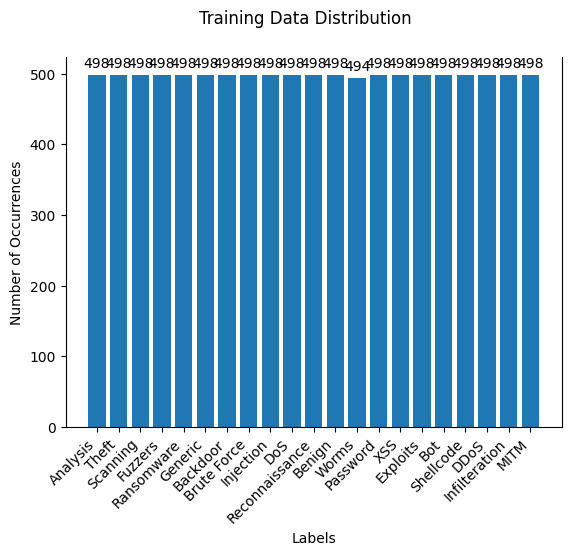

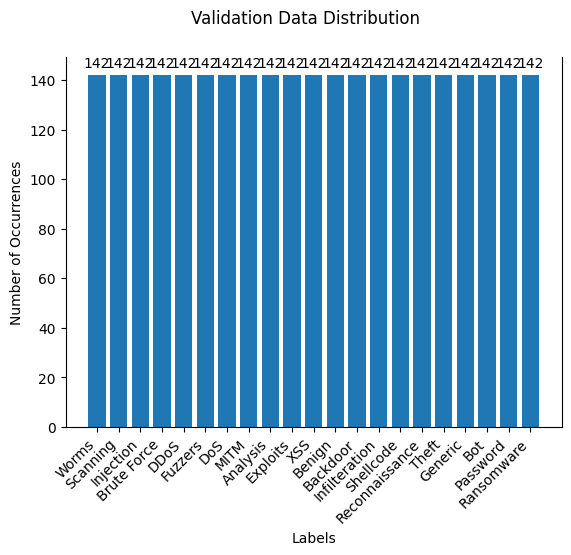

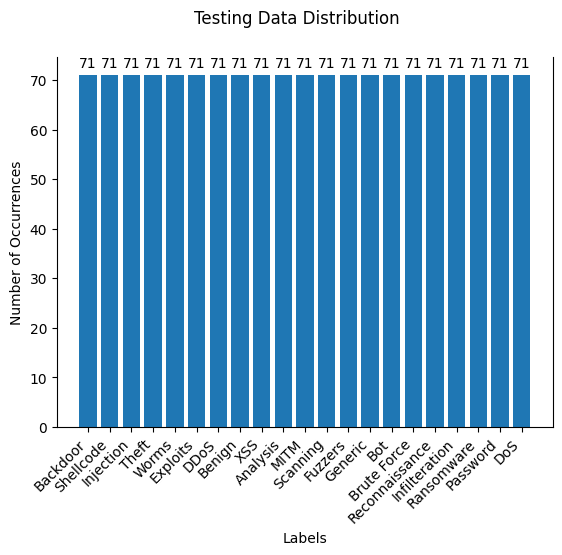

In [8]:
# We pass in the labels map to convert indexes into string labels
train_distribution, * \
    _ = plot_distribution(
        train_dataloader, title='Training Data Distribution', labels_map=label_map)
val_distribution, *_ = plot_distribution(val_dataloader,
                                         title='Validation Data Distribution', labels_map=label_map)
test_distribution, * \
    _ = plot_distribution(
        test_dataloader, title='Testing Data Distribution', labels_map=label_map)

#### 4. Training Models

This section will train and evaluate models perfomance on binary classification of the traffic data. The models include: linear SVM, Random Forest, eXtreme Gradient Boosting(XGBoost), Simple Convolution Neural Network with VGG architecture with 1 dimensional convolution (SimpleVGG1DCNN), Simple Convolution Neural Network with ResNet architecture -- involves residual layers (SimpleResNet1DCNN), an encoder only classification transformer model, and Pretrained Distilled BERT.


##### 4.1 Linear Support Vector Machine(SVM)

1 - Define and show architecture (parameters) in the defined model


In [46]:
svm_model = LinearSVM(input_size, num_classes, channels).to(device)
print(svm_model)

LinearSVM()


Lets visualize the model

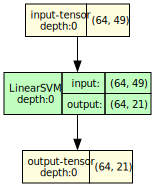

In [47]:
model_graph = draw_graph(svm_model, input_size=(batch_size, input_size), device=device, expand_nested=True)
model_graph.visual_graph

2 - Define training parameters and train the model


Training Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 3.3290, Validation Loss: 3.1371
Epoch 2/25, Training Loss: 2.7989, Validation Loss: 2.6430
Epoch 3/25, Training Loss: 2.3561, Validation Loss: 2.2397
Epoch 4/25, Training Loss: 2.0052, Validation Loss: 1.8927
Epoch 5/25, Training Loss: 1.7036, Validation Loss: 1.6134
Epoch 6/25, Training Loss: 1.5525, Validation Loss: 1.5830
Epoch 7/25, Training Loss: 1.5286, Validation Loss: 1.5651
Epoch 8/25, Training Loss: 1.5044, Validation Loss: 1.5337
Epoch 9/25, Training Loss: 1.4843, Validation Loss: 1.5134
Epoch 10/25, Training Loss: 1.4636, Validation Loss: 1.4958
Epoch 11/25, Training Loss: 1.4492, Validation Loss: 1.4859
Epoch 12/25, Training Loss: 1.4483, Validation Loss: 1.4876
Epoch 13/25, Training Loss: 1.4444, Validation Loss: 1.4800
Epoch 14/25, Training Loss: 1.4429, Validation Loss: 1.4832
Epoch 15/25, Training Loss: 1.4438, Validation Loss: 1.4827
Epoch 16/25, Training Loss: 1.4372, Validation Loss: 1.4815
Epoch 17/25, Training Loss: 1.4369, Validation Lo

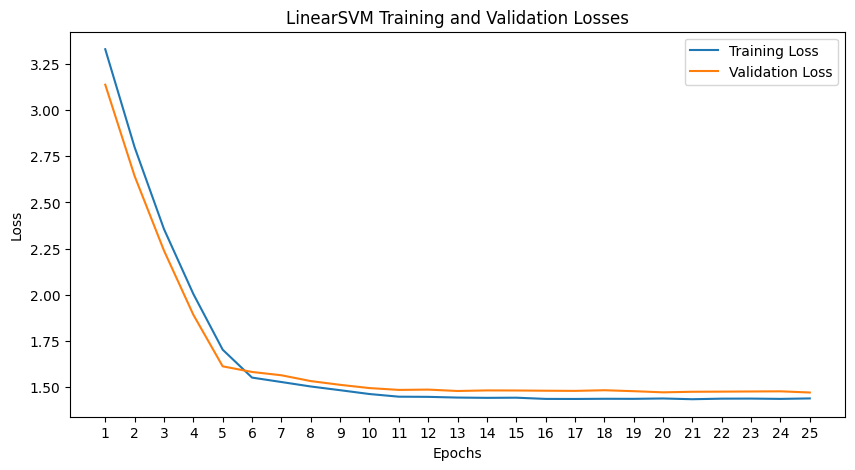

In [48]:
# SVM Training Hyper Parameters
margin = 0.2  # Hinge loss margin
learning_rate = 0.01
epochs = 25
step_size = 5  # Gradualy decay learning rate after this many steps
gamma = 0.1  # Factor of learning rate decay

optimizer = torch.optim.SGD(svm_model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model
trainer = Trainer(train_dataloader, val_dataloader, optimizer, HingeLoss(
    margin), device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(svm_model)

3 - Evaluate the model to get performance metrics


LinearSVM Metrics Summary
Accuracy: 0.0389, Precision: 0.0585, Recall: 0.0389, F1 Score: 0.0381

LinearSVM Classification Report:
                 precision    recall  f1-score   support

        Benign       0.15      0.03      0.05        71
          DDoS       0.00      0.00      0.00        71
Reconnaissance       0.07      0.11      0.08        71
     Injection       0.00      0.00      0.00        71
           DoS       0.00      0.00      0.00        71
   Brute Force       0.00      0.00      0.00        71
      Password       0.00      0.00      0.00        71
           XSS       0.30      0.08      0.13        71
 Infilteration       0.08      0.14      0.10        71
      Exploits       0.00      0.00      0.00        71
      Scanning       0.19      0.24      0.21        71
       Fuzzers       0.00      0.00      0.00        71
      Backdoor       0.00      0.00      0.00        71
           Bot       0.00      0.00      0.00        71
       Generic       0.05   

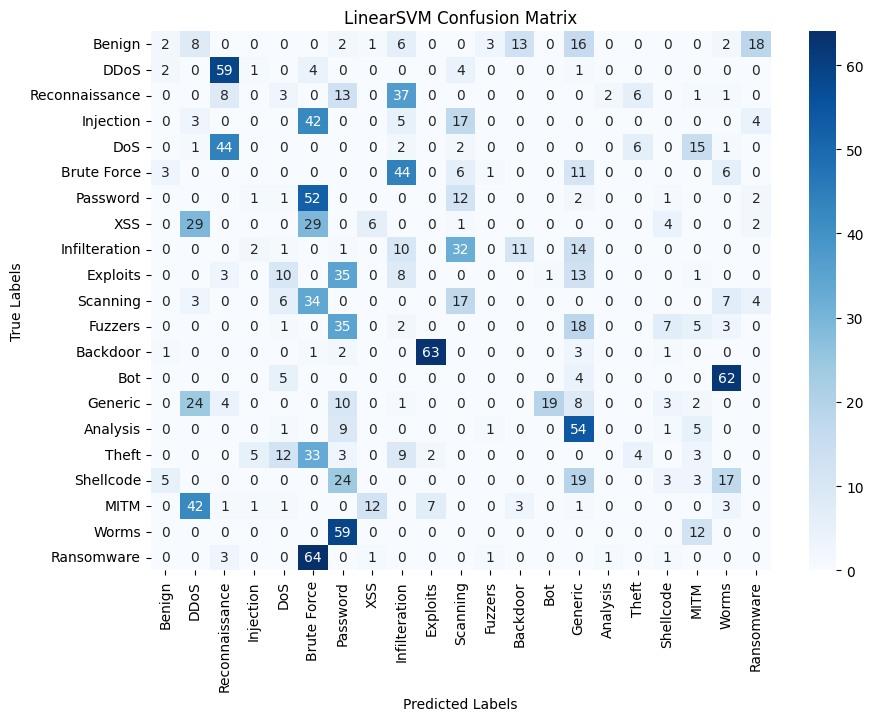

In [62]:
evaluator = ModelEvaluator(svm_model, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [61]:
save_pytorch_model(svm_model, 'svm_model_classification', '../data/trained_models')

Model: svm_model_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/svm_model_classification.model


##### 4.2 Random Forest(RF)

1 - Define and show architecture (parameters) in the defined model


In [13]:
# RF Model Hyper parameters
n_estimators = 200  # Total number of decision trees in the model
max_depth = None  # the depth of each tree

rf_model = RandomForest(n_estimators=n_estimators, max_depth=max_depth)
print(rf_model)

RandomForest()


2 - Define training parameters and train the model


In [14]:
# Collect all data from training dataloader
features_array, labels_array = collect_dataloader_data(train_dataloader)
rf_model.fit(features_array, labels_array)

# delete collected arrays to save memory
del features_array, labels_array

RandomForest fitting complete!.


3 - Evaluate the model to get performance metrics


RandomForest Metrics Summary
Accuracy: 0.9302, Precision: 0.9312, Recall: 0.9302, F1 Score: 0.9300

RandomForest Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       1.00      0.97      0.99        71
Reconnaissance       0.98      0.89      0.93        71
     Injection       0.85      0.89      0.87        71
           DoS       0.91      0.97      0.94        71
   Brute Force       1.00      1.00      1.00        71
      Password       0.94      0.92      0.93        71
           XSS       0.93      0.94      0.94        71
 Infilteration       1.00      1.00      1.00        71
      Exploits       0.76      0.80      0.78        71
      Scanning       1.00      1.00      1.00        71
       Fuzzers       0.80      0.86      0.83        71
      Backdoor       0.90      0.92      0.91        71
           Bot       1.00      1.00      1.00        71
       Generic       0

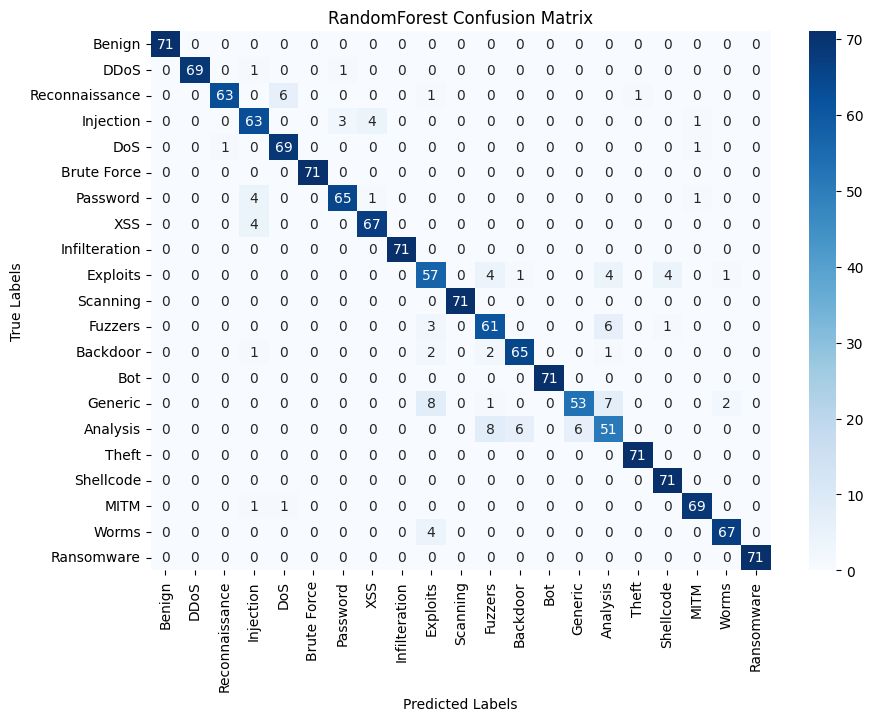

In [15]:
evaluator = ModelEvaluator(rf_model, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [16]:
save_pytorch_model(rf_model, 'rf_model_classification', '../data/trained_models')

Model: rf_model_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/rf_model_classification.model


##### 4.3 eXtreme Gradient Boosting(XGBoost)

1 - Define and show architecture (parameters) in the defined model


In [20]:
# XGBoost Model Hyper parameters
n_estimators = 150  # Number of decision trees
max_depth = 7  # Depth of each tree

xgb_model = XGBoost(n_estimators=n_estimators, max_depth=max_depth)
print(xgb_model)

XGBoost()


2 - Define training parameters and train the model


In [21]:
# Collect all data from training dataloader
features_array, labels_array = collect_dataloader_data(train_dataloader)
xgb_model.fit(features_array, labels_array)

# delete collected arrays to save memory
del features_array, labels_array

XGBoost fitting complete!.


3 - Evaluate the model to get performance metrics


XGBoost Metrics Summary
Accuracy: 0.9416, Precision: 0.9427, Recall: 0.9416, F1 Score: 0.9417

XGBoost Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       1.00      0.96      0.98        71
Reconnaissance       0.97      0.92      0.94        71
     Injection       0.89      0.92      0.90        71
           DoS       0.93      0.96      0.94        71
   Brute Force       1.00      1.00      1.00        71
      Password       0.94      0.94      0.94        71
           XSS       0.94      0.93      0.94        71
 Infilteration       1.00      1.00      1.00        71
      Exploits       0.78      0.87      0.83        71
      Scanning       0.99      1.00      0.99        71
       Fuzzers       0.91      0.90      0.91        71
      Backdoor       0.94      0.90      0.92        71
           Bot       1.00      1.00      1.00        71
       Generic       0.87      0

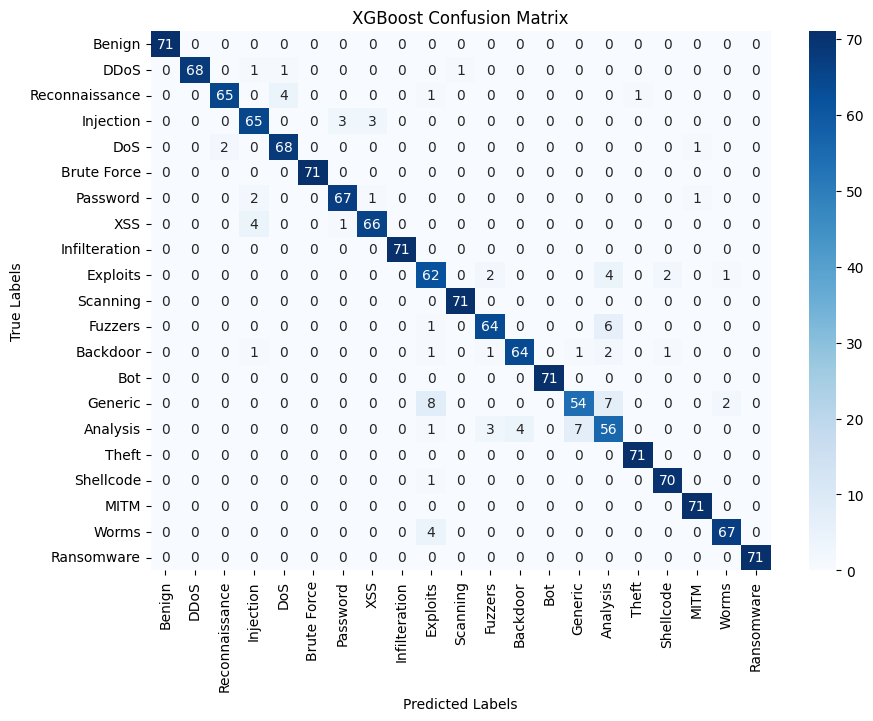

In [22]:
evaluator = ModelEvaluator(xgb_model, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [23]:
save_pytorch_model(xgb_model, 'xgb_model_classification', '../data/trained_models')

Model: xgb_model_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/xgb_model_classification.model


##### 4.4 Simple Convolution Neural Network with VGG architecture with 1 dimensional convolution (SimpleVGG1DCNN)

1 - Define and show architecture (parameters) in the defined model


In [51]:
# SimpleVGG1DCNN Model Hyper Parameters
hidden_units = 128

# Define the CNN
simpleVGG1DCNN = SimpleVGG1DCNN(channels=channels,
                                sequence_length=input_size,
                                hidden_units=hidden_units,
                                output_units=output_size,
                                ).to(device=device)

print(simpleVGG1DCNN)

SimpleVGG1DCNN(
  (input_block): Sequential(
    (0): Conv1d(1, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=128)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_block): Sequential(
    (0): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=128)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, 

Lets visualize the model

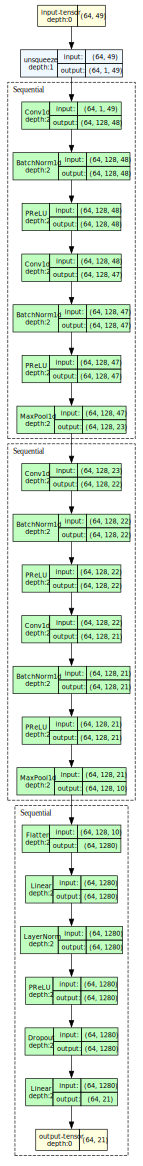

In [52]:
model_graph = draw_graph(simpleVGG1DCNN, input_size=(batch_size, input_size), device=device, expand_nested=True)
model_graph.visual_graph

2 - Define training parameters and train the model


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 0.8036, Validation Loss: 0.6040
Epoch 2/20, Training Loss: 0.4906, Validation Loss: 0.4413
Epoch 3/20, Training Loss: 0.4035, Validation Loss: 0.4006
Epoch 4/20, Training Loss: 0.3887, Validation Loss: 0.3929
Epoch 5/20, Training Loss: 0.3783, Validation Loss: 0.3911
Epoch 6/20, Training Loss: 0.3788, Validation Loss: 0.3893
Epoch 7/20, Training Loss: 0.3765, Validation Loss: 0.3970
Epoch 8/20, Training Loss: 0.3788, Validation Loss: 0.3876
Epoch 9/20, Training Loss: 0.3759, Validation Loss: 0.3932
Epoch 10/20, Training Loss: 0.3757, Validation Loss: 0.3904
Epoch 11/20, Training Loss: 0.3776, Validation Loss: 0.3889
Epoch 12/20, Training Loss: 0.3777, Validation Loss: 0.3894
Epoch 13/20, Training Loss: 0.3780, Validation Loss: 0.3972
Epoch 14/20, Training Loss: 0.3764, Validation Loss: 0.3942
Epoch 15/20, Training Loss: 0.3795, Validation Loss: 0.3938
Epoch 16/20, Training Loss: 0.3763, Validation Loss: 0.3896
Epoch 17/20, Training Loss: 0.3760, Validation Lo

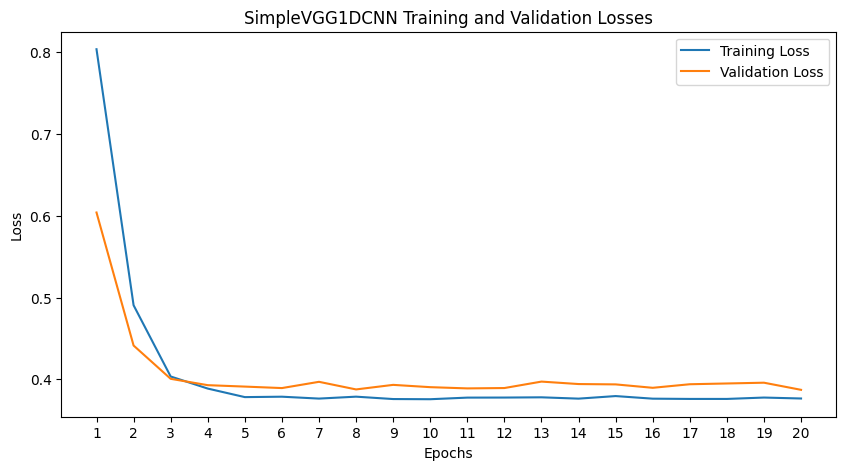

In [53]:
# simpleVGG1DCNN Training Hyper Parameters
learning_rate = 0.01
epochs = 20
step_size = 2  # Gradualy decay learning rate after this many steps
gamma = 0.1  # Factor of learning rate decay

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simpleVGG1DCNN.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model
trainer = Trainer(train_dataloader, val_dataloader, optimizer, loss,
                  device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(simpleVGG1DCNN)

3 - Evaluate the model to get performance metrics


SimpleVGG1DCNN Metrics Summary
Accuracy: 0.8719, Precision: 0.8811, Recall: 0.8719, F1 Score: 0.8712

SimpleVGG1DCNN Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       1.00      0.90      0.95        71
Reconnaissance       0.97      0.92      0.94        71
     Injection       0.68      0.70      0.69        71
           DoS       0.94      0.93      0.94        71
   Brute Force       0.96      0.99      0.97        71
      Password       0.69      0.80      0.74        71
           XSS       0.88      0.59      0.71        71
 Infilteration       0.97      0.97      0.97        71
      Exploits       0.76      0.68      0.72        71
      Scanning       0.97      0.96      0.96        71
       Fuzzers       0.63      0.79      0.70        71
      Backdoor       0.98      0.89      0.93        71
           Bot       0.99      1.00      0.99        71
       Generic    

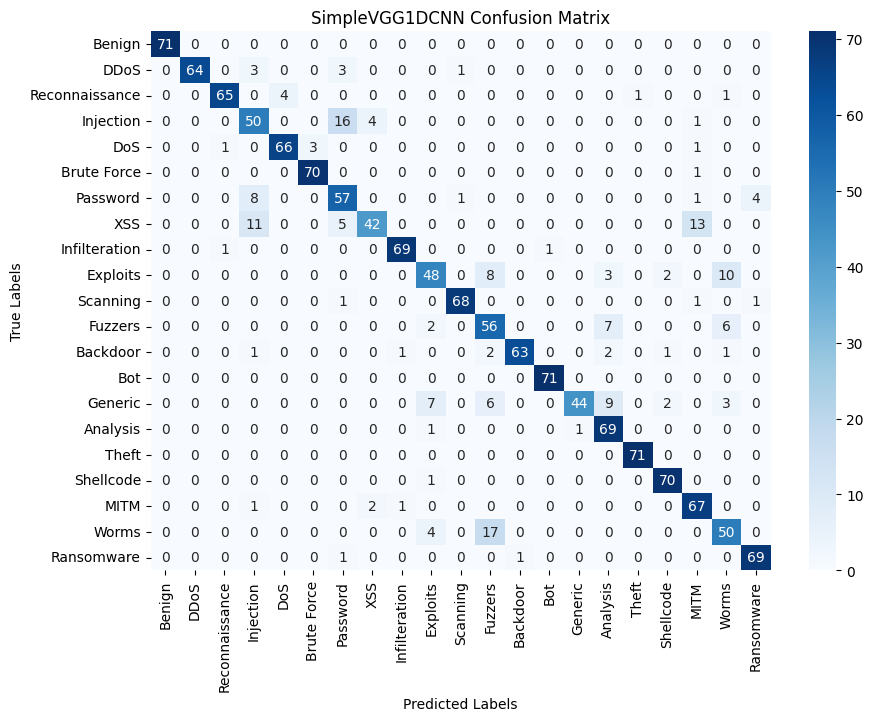

In [66]:
evaluator = ModelEvaluator(simpleVGG1DCNN, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [67]:
save_pytorch_model(simpleVGG1DCNN, 'simpleVGG1DCNN_classification', '../data/trained_models')

Model: simpleVGG1DCNN_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/simpleVGG1DCNN_classification.model


##### 4.5 Simple Convolution Neural Network with ResNet architecture 1 dimensional convolution(SimpleResNet1DCNN)

1 - Define and show architecture (parameters) in the defined model


In [56]:
# SimpleResNet1DCNN Model Hyper Parameters
hidden_units = 128

# Define the CNN
simpleReSNet1DCNN = SimpleResNet1DCNN(channels=channels,
                                      sequence_length=input_size,
                                      hidden_units=hidden_units,
                                      output_units=output_size,
                                      ).to(device=device)

print(simpleReSNet1DCNN)

SimpleResNet1DCNN(
  (initial_block): Sequential(
    (0): Conv1d(1, 128, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock1D(
      (block): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=128)
        (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): PReLU(num_parameters=128)
    )
    (1): ResidualBlock1D(
      (block): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1

Lets visualize the model

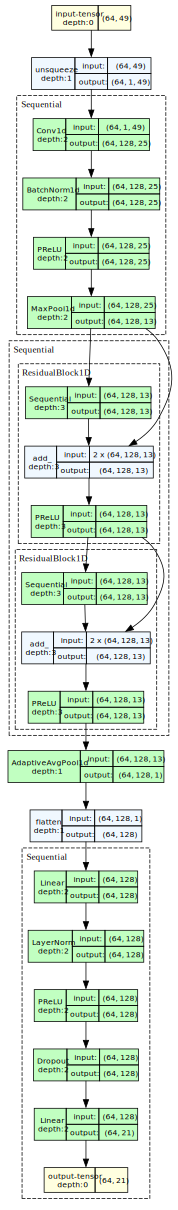

In [57]:
model_graph = draw_graph(simpleReSNet1DCNN, input_size=(batch_size, input_size), device=device, expand_nested=True)
model_graph.visual_graph

2 - Define training parameters and train the model


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 2.1897, Validation Loss: 1.3698
Epoch 2/20, Training Loss: 1.0889, Validation Loss: 0.9880
Epoch 3/20, Training Loss: 0.8606, Validation Loss: 0.7969
Epoch 4/20, Training Loss: 0.8277, Validation Loss: 0.7861
Epoch 5/20, Training Loss: 0.8150, Validation Loss: 0.7646
Epoch 6/20, Training Loss: 0.8132, Validation Loss: 0.7772
Epoch 7/20, Training Loss: 0.8152, Validation Loss: 0.7779
Epoch 8/20, Training Loss: 0.8102, Validation Loss: 0.7658
Epoch 9/20, Training Loss: 0.8131, Validation Loss: 0.8133
Epoch 10/20, Training Loss: 0.8093, Validation Loss: 0.7750
Epoch 11/20, Training Loss: 0.8092, Validation Loss: 0.7675
Epoch 12/20, Training Loss: 0.8152, Validation Loss: 0.7633
Epoch 13/20, Training Loss: 0.8105, Validation Loss: 0.7707
Epoch 14/20, Training Loss: 0.8107, Validation Loss: 0.7682
Epoch 15/20, Training Loss: 0.8097, Validation Loss: 0.7777
Epoch 16/20, Training Loss: 0.8108, Validation Loss: 0.7627
Epoch 17/20, Training Loss: 0.8076, Validation Lo

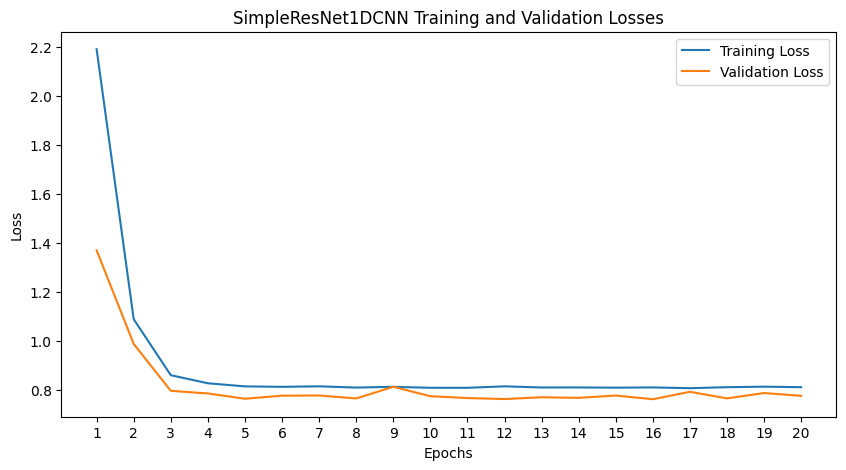

In [58]:
# simpleVGG1DCNN Training Hyper Parameters
learning_rate = 0.005
epochs = 20
step_size = 2  # Gradualy decay learning rate after this many steps
gamma = 0.1  # Factor of learning rate decay

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simpleReSNet1DCNN.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model
trainer = Trainer(train_dataloader, val_dataloader, optimizer, loss,
                  device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(simpleReSNet1DCNN)

3 - Evaluate the model to get performance metrics


SimpleResNet1DCNN Metrics Summary
Accuracy: 0.8008, Precision: 0.8122, Recall: 0.8008, F1 Score: 0.7956

SimpleResNet1DCNN Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       0.92      0.86      0.89        71
Reconnaissance       0.90      0.86      0.88        71
     Injection       0.55      0.65      0.59        71
           DoS       0.94      0.86      0.90        71
   Brute Force       0.86      0.99      0.92        71
      Password       0.66      0.58      0.62        71
           XSS       0.68      0.24      0.35        71
 Infilteration       0.97      0.87      0.92        71
      Exploits       0.61      0.72      0.66        71
      Scanning       0.91      0.99      0.95        71
       Fuzzers       0.50      0.59      0.54        71
      Backdoor       0.98      0.89      0.93        71
           Bot       0.96      1.00      0.98        71
       Gener

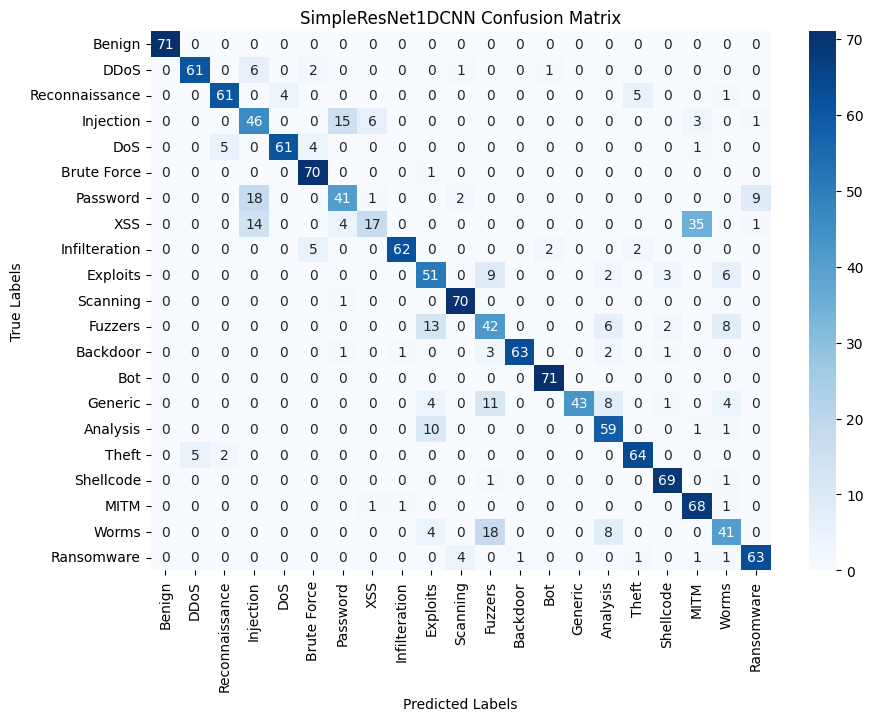

In [68]:
evaluator = ModelEvaluator(simpleReSNet1DCNN, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [70]:
save_pytorch_model(simpleReSNet1DCNN, 'simpleReSNet1DCNN_classification',
                   '../data/trained_models')

Model: simpleReSNet1DCNN_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/simpleReSNet1DCNN_classification.model


##### 4.6 Encoder Only Classificaton Transformer

1 - Define and show architecture (parameters) in the defined model


In [32]:
# Transformer Encoder Classifier model Hyper Parameters
d_model = 128  # Dimension of the transformer model
nhead = 2  # Number of Attention Heads
num_encoder_layers = 3  # Number of encoder layers

transformer_encoder_classifier = TransformerEncoderClassifier(
    input_dim=input_size, d_model=d_model, nhead=nhead,
    num_encoder_layers=num_encoder_layers, num_classes=output_size)

print(transformer_encoder_classifier)

TransformerEncoderClassifier(
  (input_projection): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): PReLU(num_parameters=128)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwis

Lets visualize the model

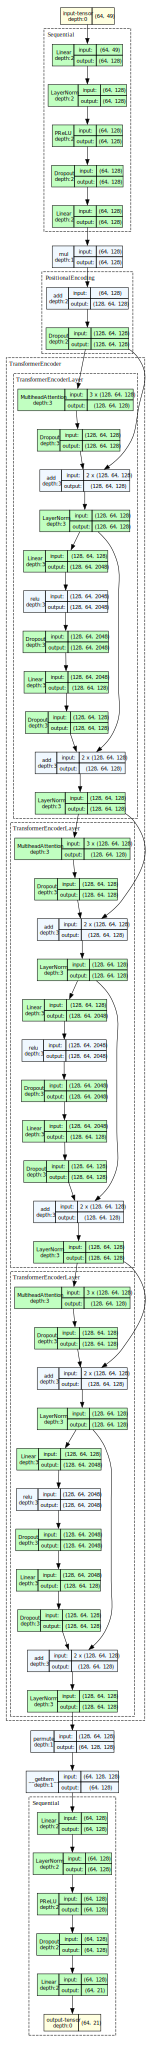

In [33]:
model_graph = draw_graph(transformer_encoder_classifier, input_size=(batch_size, input_size), device=device, expand_nested=True, roll=True)
model_graph.visual_graph

2 - Define training parameters and train the model


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 1.3530, Validation Loss: 0.7244
Epoch 2/20, Training Loss: 0.7230, Validation Loss: 0.5688
Epoch 3/20, Training Loss: 0.6350, Validation Loss: 0.5456
Epoch 4/20, Training Loss: 0.6190, Validation Loss: 0.5419
Epoch 5/20, Training Loss: 0.6064, Validation Loss: 0.5405
Epoch 6/20, Training Loss: 0.6073, Validation Loss: 0.5379
Epoch 7/20, Training Loss: 0.6082, Validation Loss: 0.5385
Epoch 8/20, Training Loss: 0.6067, Validation Loss: 0.5349
Epoch 9/20, Training Loss: 0.6107, Validation Loss: 0.5403
Epoch 10/20, Training Loss: 0.6106, Validation Loss: 0.5370
Epoch 11/20, Training Loss: 0.6120, Validation Loss: 0.5351
Epoch 12/20, Training Loss: 0.6072, Validation Loss: 0.5365
Epoch 13/20, Training Loss: 0.6100, Validation Loss: 0.5349
Epoch 14/20, Training Loss: 0.6088, Validation Loss: 0.5374
Epoch 15/20, Training Loss: 0.6092, Validation Loss: 0.5349
Epoch 16/20, Training Loss: 0.6055, Validation Loss: 0.5387
Epoch 17/20, Training Loss: 0.6125, Validation Lo

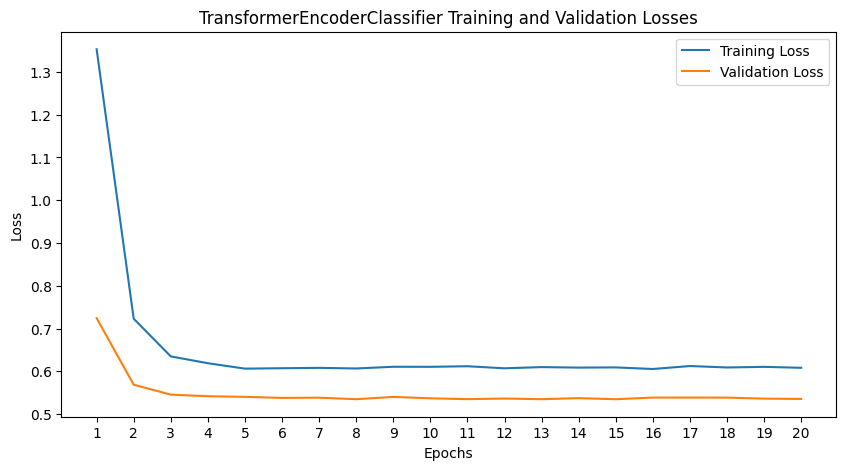

In [34]:
# simpleVGG1DCNN Training Hyper Parameters
learning_rate = 0.02
epochs = 20
step_size = 2  # Gradualy decay learning rate after this many steps
gamma = 0.1  # Factor of learning rate decay

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(transformer_encoder_classifier.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model
trainer = Trainer(train_dataloader, val_dataloader, optimizer, loss,
                  device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(transformer_encoder_classifier)

3 - Evaluate the model to get performance metrics


TransformerEncoderClassifier Metrics Summary
Accuracy: 0.8109, Precision: 0.8210, Recall: 0.8109, F1 Score: 0.8066

TransformerEncoderClassifier Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       0.88      0.90      0.89        71
Reconnaissance       0.94      0.90      0.92        71
     Injection       0.52      0.61      0.56        71
           DoS       0.94      0.87      0.91        71
   Brute Force       0.88      0.94      0.91        71
      Password       0.66      0.55      0.60        71
           XSS       0.60      0.25      0.36        71
 Infilteration       0.97      0.90      0.93        71
      Exploits       0.82      0.69      0.75        71
      Scanning       0.91      0.97      0.94        71
       Fuzzers       0.56      0.69      0.62        71
      Backdoor       1.00      0.89      0.94        71
           Bot       0.97      1.00      0.99 

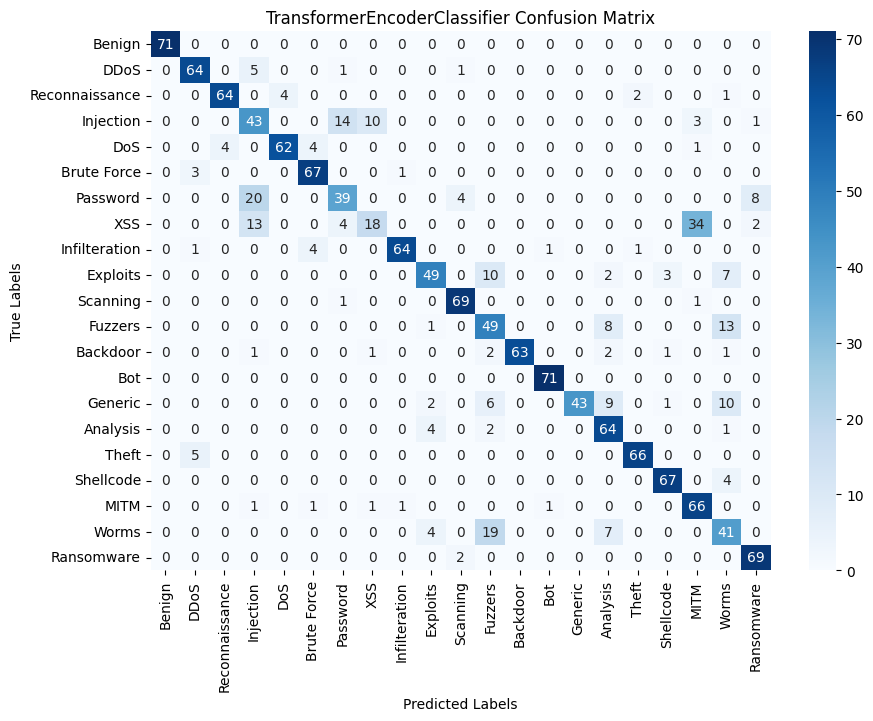

In [35]:
evaluator = ModelEvaluator(transformer_encoder_classifier, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [36]:
save_pytorch_model(transformer_encoder_classifier, 'transformer_encoder_classifier_classification',
                   '../data/trained_models')

Model: transformer_encoder_classifier_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/transformer_encoder_classifier_classification.model


##### 4.7 Pre-trained Distilled BERT

1 - Define and show architecture (parameters) in the defined model


In [37]:
# Since Distilled BERT is Pretrained there are no Model Hyper Parameters

distilled_bert = BertTransformer(input_dim=input_size, num_classes=num_classes)
print(distilled_bert)

BertTransformer(
  (feature_extractor): Sequential(
    (0): Linear(in_features=49, out_features=768, bias=True)
    (1): PReLU(num_parameters=768)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
  )
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linea

Lets visualize the model

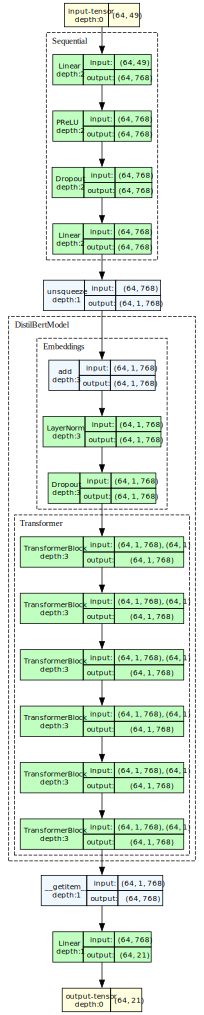

In [38]:
model_graph = draw_graph(distilled_bert, input_size=(batch_size, input_size), device=device, expand_nested=True, roll=True)
model_graph.visual_graph

2 - Define training parameters and train the model


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 0.7253, Validation Loss: 0.6693
Epoch 2/20, Training Loss: 0.5217, Validation Loss: 0.5802
Epoch 3/20, Training Loss: 0.4431, Validation Loss: 0.4178
Epoch 4/20, Training Loss: 0.4257, Validation Loss: 0.4146
Epoch 5/20, Training Loss: 0.4157, Validation Loss: 0.4113
Epoch 6/20, Training Loss: 0.4163, Validation Loss: 0.4067
Epoch 7/20, Training Loss: 0.4148, Validation Loss: 0.4063
Epoch 8/20, Training Loss: 0.4162, Validation Loss: 0.4057
Epoch 9/20, Training Loss: 0.4131, Validation Loss: 0.4061
Epoch 10/20, Training Loss: 0.4177, Validation Loss: 0.4054
Epoch 11/20, Training Loss: 0.4170, Validation Loss: 0.4077
Epoch 12/20, Training Loss: 0.4142, Validation Loss: 0.4061
Epoch 13/20, Training Loss: 0.4152, Validation Loss: 0.4055
Epoch 14/20, Training Loss: 0.4183, Validation Loss: 0.4073
Epoch 15/20, Training Loss: 0.4149, Validation Loss: 0.4072
Epoch 16/20, Training Loss: 0.4157, Validation Loss: 0.4061
Epoch 17/20, Training Loss: 0.4133, Validation Lo

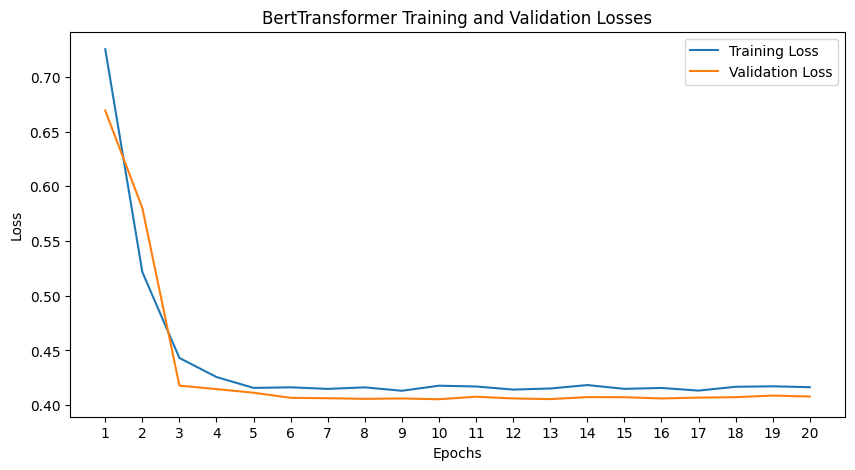

In [39]:
# simpleVGG1DCNN Training Hyper Parameters
learning_rate = 0.02
epochs = 20
step_size = 2  # Gradualy decay learning rate after this many steps
gamma = 0.1  # Factor of learning rate decay

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(distilled_bert.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model
trainer = Trainer(train_dataloader, val_dataloader, optimizer, loss,
                  device, epochs=epochs, scheduler=exp_lr_scheduler)
trainer.train(distilled_bert)

3 - Evaluate the model to get performance metrics


BertTransformer Metrics Summary
Accuracy: 0.8592, Precision: 0.8729, Recall: 0.8592, F1 Score: 0.8580

BertTransformer Classification Report:
                 precision    recall  f1-score   support

        Benign       1.00      1.00      1.00        71
          DDoS       0.96      0.90      0.93        71
Reconnaissance       0.97      0.90      0.93        71
     Injection       0.68      0.66      0.67        71
           DoS       0.94      0.96      0.95        71
   Brute Force       0.99      0.94      0.96        71
      Password       0.65      0.85      0.74        71
           XSS       0.84      0.52      0.64        71
 Infilteration       0.99      0.97      0.98        71
      Exploits       0.88      0.62      0.73        71
      Scanning       0.95      0.99      0.97        71
       Fuzzers       0.60      0.72      0.65        71
      Backdoor       0.97      0.89      0.93        71
           Bot       0.99      1.00      0.99        71
       Generic  

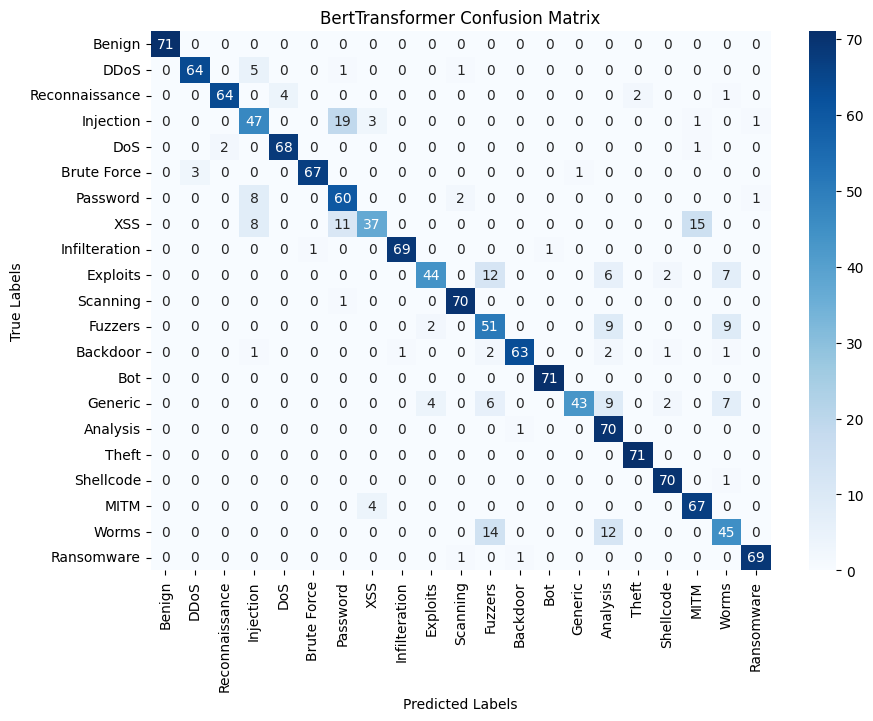

In [40]:
evaluator = ModelEvaluator(distilled_bert, test_dataloader, label_map, device=device)
evaluator.evaluate()

4 - Save trained model


In [71]:
save_pytorch_model(distilled_bert, 'distilled_bert_classification',
                   '../data/trained_models')

Model: distilled_bert_classification saved!
Path: /Users/mbeatle/Desktop/code_200039322/data/trained_models/distilled_bert_classification.model
